In [10]:
import os, sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from bengali_nlp.bengali_tools.bengali_preprocessing import preprocess_bangla
import bengali_nlp.bengali_classifier.geoparser as geo


import bengali_nlp.bengali_timeseries.eventDetection as ed
from bengali_nlp.bengali_timeseries.timeseries import TimeSeries

# Load Prerequisites

### Load Data and Predictions

In [11]:
df_name = "exact_scrape"
df = pd.read_csv(os.path.join("predictions", f"{df_name}_dataset.csv"), index_col = 0)

In [12]:
import pickle

with open(os.path.join("predictions", df_name, "LinearSVC_predictions.pkl"), "rb") as f:
    preds = pickle.load(f)

### Load Load Geoparser

In [13]:
geoparser = geo.OccurrenceGeoParser()

In [14]:
txt = list(df[preds]['content'].sample())[0]

In [15]:
geoparser.locate(txt)

('chittagong',)

# Event Detector

In [60]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Event:
    dates: Tuple[datetime, datetime]
    locs: List[str]
        
    def __repr__(self):
        locs_str = ",".join(loc.capitalize() for loc in self.locs)
        start_date_str = self.dates[0].strftime("%B %d, %Y")
        end_date_str = self.dates[1].strftime("%B %d, %Y")
        return f"Flood event from {start_date_str} to {end_date_str} in {locs_str}"

from collections import Counter
class NewsMediaEventDector(ed.EventDetector):
    def __init__(self, 
                 articles, 
                 dates,
                 geoparser = geo.OccurrenceGeoParser(), 
                 normalization_ts = None, 
                 date_range = (datetime(2016, 1, 1), datetime(2021, 12, 31))
                ):
        
        self.date_range = date_range
        self.margin = None
        #if normalization_ts is None:
        #    self.normalization_ts = TimeSeries.from_dates(dates, date_range=date_range)
        #else:
        self.normalization_ts = normalization_ts
            
        # Model is HMM, each event can cover a time and a place or a few places. Do Simple.
        self.articles = articles
        self.dates = dates
        self.geoparser = geoparser
        
        self.locations = np.array([geoparser.locate(article) for article in articles])
        
    def events(self, article_thres = 4, thres = 0.008, width = 20, step = timedelta(days=1), date_range = None):
        # Events are peaks which occur in the same general division. They may span multiple regions however
        if thres is None:
            thres = article_thres
        
        if date_range is None:
            date_range = self.date_range
        
        start, end = date_range
        events = []
        locs_in_flood = {}
        
        for i in range((end - start)//step):
            w_start = start + i * step
            w_end = w_start + width * step
            mentions = self.most_common_mentioned(date_range = (w_start, w_end))
            
            # Normalize results
            normalization = 1
            if self.normalization_ts is not None:
                normalization = np.sum(self.normalization_ts.y[(self.normalization_ts.X >= w_start) & (self.normalization_ts.X <= w_end)])
            
            for loc in geoparser.locations():
                is_flood_event = (mentions[loc] > article_thres) and (mentions[loc]/(normalization+1) > thres)
                if is_flood_event and loc not in locs_in_flood:
                    locs_in_flood[loc] = w_start
                elif (not is_flood_event) and loc in locs_in_flood:
                    s = locs_in_flood[loc]
                    del locs_in_flood[loc]
                    
                    events.append(Event(dates = (s, w_start), locs = [loc]))
                    
        #for loc in locs_in_flood:
        #    s = locs_in_flood[loc]
        #    del locs_in_flood[loc]
        #    events.append(Event(dates = (s, end), locs = [loc]))
            
        self.flood_events = events
        self.margin = width * step
        return events
    
    def most_common_mentioned(self, date_range = (datetime(2018, 1, 1), datetime(2021, 1, 5)) ):
        within_range = (self.dates >= date_range[0]) & (self.dates <= date_range[1])
        return Counter(loc for locs in self.locations[within_range] for loc in locs)
    
    def articles_for_flood_event(self, event, width = None):
        if width is None:
            width = self.margin
        if self.margin is None:
            width = timedelta(0)
        
        s, t = event.dates
        within_range = (self.dates >= s) & (self.dates <= t + width)
        within_loc = np.array([any(loc in targ for loc in event.locs) for targ in self.locations])
        return self.articles[within_loc & within_range]
    
    def plot(self, loc):
        X = [ev.dates[0] + (ev.dates[1] - ev.dates[0])/2 for ev in self.flood_events if ev.locs[0] == loc]
        y = [len(self.articles_for_flood_event(ev)) for ev in self.flood_events if ev.locs[0] == loc]
        plt.scatter(X, y)
        for a, b in zip(X, y):
            plt.annotate(a.strftime("%b/%d/%y"), (a, b))

In [61]:
eventDetector = NewsMediaEventDector(df['content'][preds], 
                                     df['date'][preds].apply(datetime.fromisoformat), 
                                     normalization_ts=TimeSeries.from_dates(df['date'].apply(datetime.fromisoformat)).smoothed(15))

In [19]:
start = datetime(2017, 1, 1)
step = timedelta(days = 20)
for i in range(50):
    end = start + step
    st_str = start.strftime("%B %d, %Y")
    ed_str = end.strftime("%B %d, %Y")
    print(f"Within Range {st_str}-{ed_str}")
    print(eventDetector.most_common_mentioned(date_range=(start, end) ))
    print()
    start = end

Within Range January 01, 2017-January 21, 2017
Counter({'mymensingh': 2})

Within Range January 21, 2017-February 10, 2017
Counter()

Within Range February 10, 2017-March 02, 2017
Counter()

Within Range March 02, 2017-March 22, 2017
Counter({'rangpur': 1})

Within Range March 22, 2017-April 11, 2017
Counter({'chittagong': 1})

Within Range April 11, 2017-May 01, 2017
Counter({'sylhet': 4, 'rajshahi': 2, 'dhaka': 1, 'chittagong': 1, 'mymensingh': 1})

Within Range May 01, 2017-May 21, 2017
Counter({'dhaka': 2, 'rajshahi': 1, 'sylhet': 1})

Within Range May 21, 2017-June 10, 2017
Counter({'chittagong': 5, 'barisal': 2, 'sylhet': 2, 'khulna': 1, 'rajshahi': 1, 'dhaka': 1})

Within Range June 10, 2017-June 30, 2017
Counter({'chittagong': 3, 'rajshahi': 2, 'sylhet': 2})

Within Range June 30, 2017-July 20, 2017
Counter({'sylhet': 7, 'rangpur': 4, 'chittagong': 4, 'rajshahi': 3, 'dhaka': 2, 'khulna': 1})

Within Range July 20, 2017-August 09, 2017
Counter({'chittagong': 5, 'sylhet': 2, 'dha

In [62]:
flood_events = eventDetector.events(article_thres=4, thres=0.003)
flood_events

[Flood event from May 03, 2016 to May 24, 2016 in Chittagong,
 Flood event from July 09, 2016 to July 30, 2016 in Rangpur,
 Flood event from July 13, 2016 to July 30, 2016 in Dhaka,
 Flood event from August 01, 2016 to August 02, 2016 in Dhaka,
 Flood event from April 15, 2017 to April 17, 2017 in Sylhet,
 Flood event from May 11, 2017 to June 01, 2017 in Chittagong,
 Flood event from June 19, 2017 to July 10, 2017 in Sylhet,
 Flood event from July 04, 2017 to July 26, 2017 in Chittagong,
 Flood event from August 08, 2017 to August 15, 2017 in Mymensingh,
 Flood event from July 25, 2017 to August 17, 2017 in Rangpur,
 Flood event from July 27, 2017 to August 17, 2017 in Dhaka,
 Flood event from May 25, 2018 to June 15, 2018 in Chittagong,
 Flood event from June 02, 2018 to June 21, 2018 in Sylhet,
 Flood event from June 20, 2018 to July 06, 2018 in Rangpur,
 Flood event from August 29, 2018 to September 19, 2018 in Dhaka,
 Flood event from April 14, 2019 to May 03, 2019 in Barisal,
 Fl

In [33]:
flood_event = flood_events[4]
print(flood_event)
print("\n\n\n".join(eventDetector.articles_for_flood_event(flood_event)))

Flood event from April 15, 2017 to April 17, 2017 in Sylhet
সুজন মিয়ার বয়স ১৫ কি ১৬। পঞ্চম শ্রেণি পাস করে আর স্কুলে যাওয়া হয়নি। বাবার সঙ্গে কৃষিকাজেই সময় দেয় সে। এ সময়টায় প্রতিবছরের মতো হাওরে ধান কাটা ও মাড়াইয়ে ব্যস্ত থাকার কথা ছিল। কিন্তু এই সুজন এখন সুনামগঞ্জ শহরের স্টেশন সড়কের কালীবাড়ি মোড়ে। এখানে শ্রম বিক্রির জন্য জড়ো হয় তার মতো অভাবী মানুষেরা।
সুজনের বাড়ি সদর উপজেলার মোল্লাপাড়া ইউনিয়নের বেতগঞ্জ গ্রামে। দুই ভাই, দুই বোনের মধ্যে সে তৃতীয়। গ্রামের পাশে দেখার হাওরে তাদের তিন একর জমিতে বোরো ধান ছিল। এখন সব পানির নিচে। ধান নেই, ঘরে খাবার নেই। পাঁচ দিন ধরে সে শহরে, কাজ খুঁজছে।
কাল বৃহস্পতিবার সকালে কথা হয় ওর সঙ্গে। বলল, ‘বাবার শরীর খারাপ, ঘরে আটজন মানুষ। বড় ভাইও কাজ খুঁজতেছে। আমিও শহরে কাজের লাগি আইছি। কিন্তু কাজ করছি মাত্র দুই দিন। এখানে মানুষ বেশি। কাজ পাওয়া যায় কম।’ তার দুঃখ, ছোট হওয়ার তার মজুরিও কম।
শুধু সুজন নয়, হাওরে ফসলহানির পর সুনামগঞ্জে শ্রমের হাটে অভাবী মানুষের ভিড় ক্রমশ বাড়ছে। কালীবাড়ি মোড়ে দেড় শ থেকে দুই শ নারী-পুরুষের ভিড়। সবাই এসেছে শ্রম বিক্রির জন্য।
সদর উপজেলার শেখেরগাঁও 

In [34]:
[fe for fe in flood_events if "dhaka" in fe.locs]

[Flood event from July 13, 2016 to July 30, 2016 in Dhaka,
 Flood event from August 01, 2016 to August 02, 2016 in Dhaka,
 Flood event from July 27, 2017 to August 17, 2017 in Dhaka,
 Flood event from August 29, 2018 to September 19, 2018 in Dhaka,
 Flood event from July 01, 2019 to July 23, 2019 in Dhaka,
 Flood event from September 13, 2019 to October 04, 2019 in Dhaka,
 Flood event from June 08, 2020 to June 10, 2020 in Dhaka,
 Flood event from June 12, 2020 to August 19, 2020 in Dhaka]

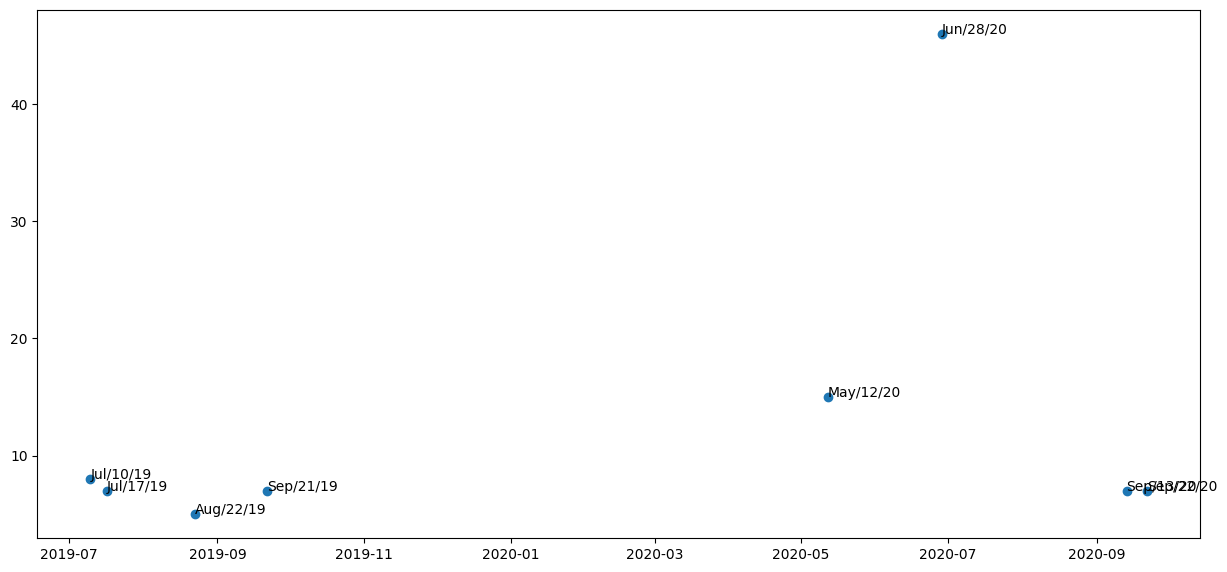

In [67]:
fig = plt.figure(figsize=(15,7), dpi= 100, edgecolor='k')
eventDetector.plot(loc = 'rajshahi')